In [1]:
import numpy as np
import uproot as up
import pandas as pd
import matplotlib.pyplot as plot
import matplotlib.mlab as mlab
from scipy.stats import norm
import pylandau
import torch
import awkward as awk

In [2]:
import datetime
x = datetime.datetime.now()
today = x.strftime("%B_%d")
import os
def checkdir(path):
    if not os.path.exists(path): 
        os.makedirs(path)

#### Set any parameters here to select the root file and prepare the plots

In [3]:
# particle = "pi"
particle = "mu"
length = "1.5"
length_dict = {
    "2.5" : "2_5",
    "2" : "2",
    "1.5" : "1_5"
}
color_dict = {
    "pi" : "green",
    "mu" : "blue"
}

In [6]:
model_date = "July_22"
today = "July_30"
model_path = "models/" + model_date + "/"
checkdir(model_path)

samples_path = "data/samples/" + today + "/"
checkdir(samples_path)

test_data_path = "data/test/" + today + "/"
checkdir(test_data_path)

test_dist_path = "plots/test_distributions/" + today + "/"
checkdir(test_dist_path)

#### Nest, open the root file with uproot and save the times to a Numpy Array

In [27]:
samples = torch.load(samples_path+"July_25_mu_1k_samples.pt")[:1000000]
layers = torch.load(samples_path+"July_25_mu_1k_layers.pt")[:1000000]
events = torch.load(samples_path+"July_25_mu_1k_events.pt")[:1000000]
hit_idx_max = torch.load(samples_path+"July_25_mu_1k_hit_idx_max.pt")[:1000000]

In [28]:
metadata = torch.cat((events.unsqueeze(0),layers.unsqueeze(0)),0)

times: list of 28 lists  
first idx is layer idx  
second idx is event idx

In [29]:
threshold = 2
times = [[] for _ in range(28)]
times[0].append(min(samples[0:int(hit_idx_max[0][0])]))
for i in range(len(hit_idx_max)): #event loop
    for j in range(len(hit_idx_max[i]) - 1): #layer_loop
        curr_times = samples[int(hit_idx_max[i][j]):int(hit_idx_max[i][j+1])]
        if(len(curr_times) > threshold):
            times[j].append(min(curr_times))

In [30]:
len(times[0])

37

#### Now we can loop over all events with the first index of the array and cut events with <2 optical photons
Goal: skip events with only 1 hit (noise) and search remaining events for first photon, ie photon with lowest time. Take that time 

In [41]:
def avg_time(num,event_times):
    ten_sorted_times = sorted(event_times)[:num]
    return sum(ten_sorted_times) / len(ten_sorted_times)

In [42]:
import torch

def process_data(metadata, datapoints):
    num_events = len(set(metadata[0]))
    num_layers = len(set(metadata[1]))
    
    # Create output tensor
    output = torch.zeros(num_events, num_layers, 11)
    
    # Create a dictionary to store data for each (event, layer) pair
    event_layer_data = {}
    
    # Group datapoints by event and layer
    for i, (event, layer, time) in enumerate(zip(metadata[0], metadata[1], datapoints)):
        if (event, layer) not in event_layer_data:
            event_layer_data[(event, layer)] = []
        event_layer_data[(event, layer)].append(time)
    
    # Process data for each event and layer
    for (event, layer), times in event_layer_data.items():
        times_tensor = torch.tensor(times)
        sorted_times, _ = torch.sort(times_tensor)
        lowest_10 = sorted_times[:10]
        
        # Pad with zeros if less than 10 datapoints
        padded_lowest_10 = torch.nn.functional.pad(lowest_10, (0, 10 - len(lowest_10)))
        
        # Populate output tensor
        output[event, layer, :10] = padded_lowest_10
        output[event, layer, 10] = len(times)
    
    return output


datapoints = torch.tensor([1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0])

result = process_data(metadata, datapoints)
print(result.shape)  # Should be torch.Size([3, 4, 11])

RuntimeError: [enforce fail at alloc_cpu.cpp:75] err == 0. DefaultCPUAllocator: can't allocate memory: you tried to allocate 26164813563597104 bytes. Error code 12 (Cannot allocate memory)

In [ ]:
results

In [5]:
#Minimum number of pixels to be hit for us to accept event
threshold = 10
use_avg = False

In [6]:
accepted_times = []
avg_accepted_times = []
rel_accepted_times = []

duplicates = 0
total = 0
total_cells = []

skipped = 0
num_list = []
#First loop over events
for event_num in range(len(cells)):
    
    #skip events with less than 2 photons
#     if(times[event_num].shape[0] < threshold): continue
    
    #Keep track of which cell IDs are hit
    curr_list = []
    for photon_num in range(len(cells[event_num])):
        if(cells[event_num][photon_num] in curr_list):
            duplicates += 1
        else:
            curr_list.append(cells[event_num][photon_num])
        if(cells[event_num][photon_num] not in total_cells):
            total_cells.append(cells[event_num][photon_num])
        total += 1
    num_list.append(len(curr_list))
    #check if 2 unique pixels are hit
    if(len(curr_list) < threshold): 
        skipped += 1
        continue
    accepted_times.append(min(times[event_num]))
    avg_accepted_times.append(avg_time(threshold,times[event_num]))
#     if(len(curr_list) == 15):
#         print(f"event #{event_num}")
print(f"total: {total} | duplicates: {duplicates} | ratio: {duplicates / total} | num unique cells hit: {len(total_cells)} | skipped: {skipped}")

total: 406858 | duplicates: 12761 | ratio: 0.03136475133830476 | num unique cells hit: 6471 | skipped: 0


#### We can plot the times in a histogram to visualize the result

#### Now we need to calculate the standard deviation and mean of this distribution

resolution (sigma): 0.182 | mean: 10.52 | FWHM: 0.427


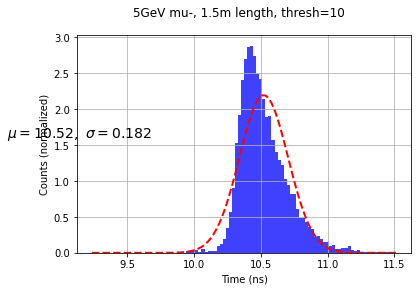

In [7]:
plot_times = avg_accepted_times if use_avg else accepted_times

fig, axs = plot.subplots(1, 1)

(mu, sigma) = norm.fit(plot_times)
n, bins, patches = plot.hist(plot_times, 100, facecolor=color_dict[particle], alpha=0.75, density=True)
fig.suptitle(f"5GeV {particle}-, {length}m length, thresh={threshold}")

y = norm.pdf( bins, mu, sigma)
l = axs.plot(bins, y, 'r--', linewidth=2)
axs.set_xlabel('Time (ns)')
axs.set_ylabel('Counts (normalized)')
axs.grid(True)
axs.text(8.6,1.6,r'$\mu=%4.2f,\ \sigma=%4.3f$'%(mu,sigma),fontsize=14)

fig.show()
extra_str = "_avg" if use_avg else ""
# fig.savefig(f"plots/June_6/{particle}_5GeV_{length_dict[length]}m_10k_events_{threshold}g_thresh{extra_str}.svg")
print("resolution (sigma): %4.3f | mean: %4.2f | FWHM: %4.3f" %(sigma,mu,(2.35 * sigma)))

In [38]:
counts = []
counts_cut = []
for i in range(times.shape[0]):
    count = len(times[i])
    counts.append(len(times[i]))
    if(count < 10 or count > 250):continue
    counts_cut.append(len(times[i]))
max_count = max(counts_cut)
min_count = min(counts_cut)
n_bins = max_count - min_count

Mean: 40.69 | Sigma: 12.150


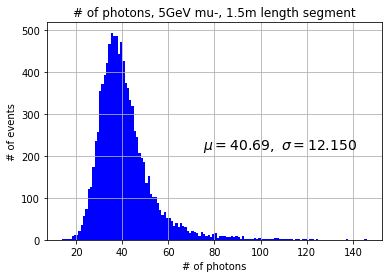

In [42]:
(mu, sigma) = norm.fit(counts_cut)
n, bins, patches = plot.hist(counts_cut, bins=n_bins, density = False,facecolor=color_dict[particle])
plot.title(f"# of photons, 5GeV {particle}-, {length}m length segment")
plot.xlabel("# of photons")
plot.ylabel("# of events")
plot.text(75,215,r'$\mu=%4.2f,\ \sigma=%4.3f$'%(mu,sigma),fontsize=14)
plot.grid(True)

plot.plot
plot.savefig(f"plots/June_6/counts_{particle}_5GeV_{length_dict[length]}m_10k_events_{threshold}g_thresh.svg")
print("Mean: %4.2f | Sigma: %4.3f"%(mu,sigma))

In [99]:
uproot_path = f"~/cworkdir/eic/work_eic/root_files/time_res/one_segment_test/mu_5GeV_1kevents_1_5m_1cm_3cm_test.edm4hep.root:events"
events = up.open(uproot_path)
cells = events["HcalBarrelHits/HcalBarrelHits.cellID"].array(library='np')
x_pos_branch = events["HcalBarrelHits/HcalBarrelHits.position.x"].array(library='np')
y_pos_branch = events["HcalBarrelHits/HcalBarrelHits.position.y"].array(library='np')
z_pos_branch = events["HcalBarrelHits/HcalBarrelHits.position.z"].array(library='np')

In [100]:
duplicates = 0
total = 0
total_cells = []
for i in range(len(cells)):
    curr_list = []
    for j in range(len(cells[i])):
        if(cells[i][j] in curr_list):
            duplicates += 1
        else:
            curr_list.append(cells[i][j])
        if(cells[i][j] not in total_cells):
            total_cells.append(cells[i][j])
        total += 1
print(f"total: {total} | duplicates: {duplicates} | ratio: {duplicates / total} | num unique cells hit: {len(total_cells)}")

total: 40495 | duplicates: 1251 | ratio: 0.030892702802815163 | num unique cells hit: 2547


In [101]:
np.sqrt(3) / ((50 * 0.0001))

346.41016151377545

In [102]:
x_pos = []
for i in range(len(x_pos_branch)):
    for j in range(len(x_pos_branch[i])):
        x_pos.append(x_pos_branch[i][j])
y_pos = []
for i in range(len(y_pos_branch)):
    for j in range(len(y_pos_branch[i])):
        y_pos.append(y_pos_branch[i][j])
z_pos = []
for i in range(len(z_pos_branch)):
    for j in range(len(z_pos_branch[i])):
        if(z_pos_branch[i][j] > 767.45):
            z_pos.append(z_pos_branch[i][j])

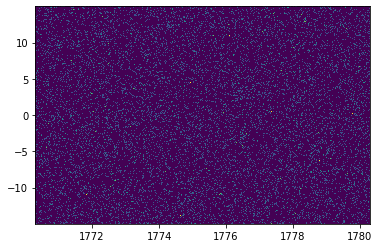

In [106]:
plot.hist2d(x_pos,y_pos,500)
plot.show()

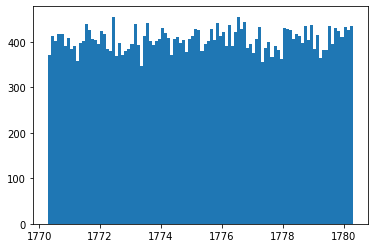

In [107]:
plot.hist(x_pos,100)
plot.show()

# OLD

In [180]:
# accepted_times = []

# #Note - array.shape[0] gives the first dimension of the array
# for event_num in range(times.shape[0]):
#     if(times[event_num].shape[0] < 2): continue
#     if(min(times[event_num]) > 12.5 or min(times[event_num]) < 9): continue
#     accepted_times.append(min(times[event_num]))

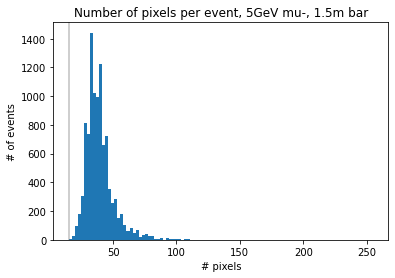

In [74]:
plot.hist(num_list,100)
plot.title("Number of pixels per event, 5GeV mu-, 1.5m bar")
plot.xlabel("# pixels")
plot.ylabel("# of events")
plot.axvline(x=15,color='gray',alpha=0.5)
plot.savefig("./plots/pixels.jpg")
plot.show()